In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Cardetails.csv')

In [3]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500.0,Diesel,Individual,Manual,First Owner,NaN,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000.0,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000.0,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000.0,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000.0,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [4]:
df.isnull().sum()

name                0
year                0
selling_price       0
km_driven         813
fuel                0
seller_type         0
transmission        0
owner               0
mileage          1011
engine           1008
max_power         215
torque            222
seats             221
dtype: int64

In [5]:
if 'engine' in df.columns:
    df['engine'] = df['engine'].str.replace('CC', '', regex=False).str.strip()
    df['engine'] = pd.to_numeric(df['engine'], errors='coerce')
if 'max_power' in df.columns:
    df['max_power'] = df['max_power'].str.replace('bhp', '', regex=False).str.strip()
    df['max_power'] = pd.to_numeric(df['max_power'], errors='coerce')
if 'milage' in df.columns:
    df['mileage'] = df['mileage'].str.replace('Kmpl', '', regex=False).str.strip()
    df['mileage'] = pd.to_numeric(df['mileage'], errors='coerce')

In [6]:
y = df['selling_price']
X=df.drop(['name','torque','selling_price'], axis=1)

In [7]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [8]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [11]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [12]:
numerical_features = numerical_cols.tolist()
categorical_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols).tolist()
all_features = numerical_features + categorical_features

In [13]:
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_features, index=X_train.index)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=all_features, index=X_test.index)

In [14]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

In [15]:
xgb_model.fit(
    X_train_preprocessed_df, y_train,
    eval_set=[(X_test_preprocessed_df, y_test)],
    verbose=100
)

[0]	validation_0-rmse:734688.05728
[100]	validation_0-rmse:146608.84243
[200]	validation_0-rmse:143450.64059
[300]	validation_0-rmse:143076.38519
[400]	validation_0-rmse:142305.81854
[500]	validation_0-rmse:141942.63767
[600]	validation_0-rmse:141666.90235
[700]	validation_0-rmse:141582.00433
[800]	validation_0-rmse:141562.84362
[900]	validation_0-rmse:141526.44113
[999]	validation_0-rmse:141424.38651


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [16]:
y_pred = xgb_model.predict(X_test_preprocessed_df)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nXGBoost Model Performance:")
print(f"MAE: ${mae:.2f}")
print(f"MSE: ${mse:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Approximate Average Error: {mae/y_test.mean():.2%}")


XGBoost Model Performance:
MAE: $70949.03
MSE: $20000857023.22
RMSE: $141424.39
R² Score: 0.9695
Approximate Average Error: 11.14%


In [17]:
sample_prediction = xgb_model.predict(X_test_preprocessed_df[:2])
print(f"\nSample prediction: ${sample_prediction[0]:.2f}")
print(f"Actual value: ${y_test.iloc[0]:.2f}")


Sample prediction: $170565.69
Actual value: $198000.00


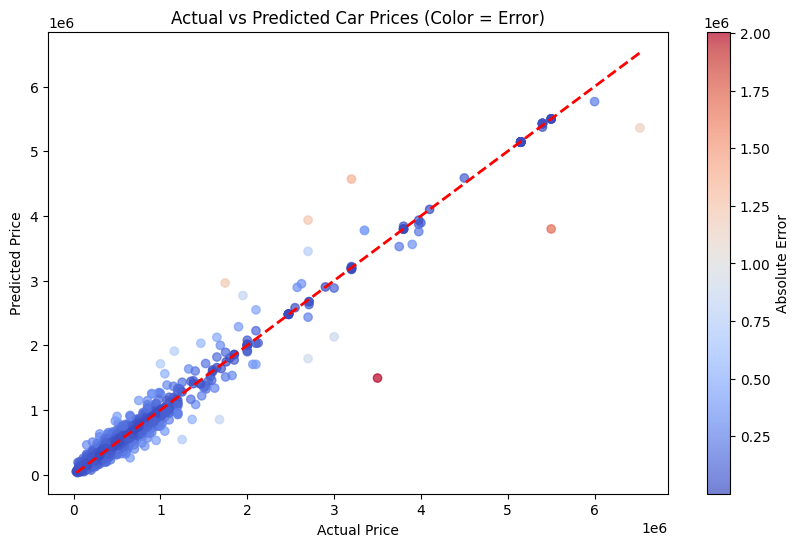

In [18]:
errors = np.abs(y_test - y_pred)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, c=errors, cmap='coolwarm', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.colorbar(label='Absolute Error')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Car Prices (Color = Error)')
plt.show()